In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Loading and Visualizing the CIFAR-10 Dataset

In [2]:
# Data augmentation + normalization for training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# CIFAR-10 class labels
classes = train_dataset.classes
print("CIFAR-10 Classes:", classes)

100%|██████████| 170M/170M [00:02<00:00, 62.3MB/s]


CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


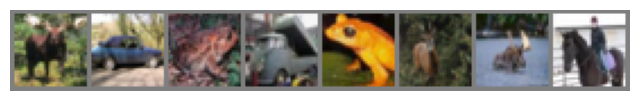

Labels: ['deer', 'automobile', 'frog', 'truck', 'frog', 'deer', 'deer', 'horse']


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", [classes[label] for label in labels[:8]])

# Building the CNN Architecture

Input: 3 x 32 x 32,
Conv2D(32) - ReLU - MaxPool,
Conv2D(64) - ReLU - MaxPool,
Conv2D(128) - ReLU - Dropout,
Flatten,
FC(256) - ReLU,
FC(10) - Output

In [ ]:
# Define the Model Class

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # after 3 pools, image becomes 4x4
        self.fc2 = nn.Linear(256, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 64x8x8
        x = self.pool(F.relu(self.conv3(x)))  # 128x4x4
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        embedding = F.relu(self.fc1(x))  # we’ll use this as the FAISS embedding
        out = self.fc2(embedding)
        return out, embedding

In [7]:
# Set Up Model, Loss, and Optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Train the CNN Model

def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [9]:
train(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10], Loss: 1093.7087, Accuracy: 48.96%
Epoch [2/10], Loss: 773.2186, Accuracy: 65.11%
Epoch [3/10], Loss: 636.5995, Accuracy: 71.23%
Epoch [4/10], Loss: 552.4302, Accuracy: 75.18%
Epoch [5/10], Loss: 480.3601, Accuracy: 78.38%
Epoch [6/10], Loss: 429.4786, Accuracy: 80.80%
Epoch [7/10], Loss: 379.5554, Accuracy: 82.81%
Epoch [8/10], Loss: 337.2151, Accuracy: 84.73%
Epoch [9/10], Loss: 299.9411, Accuracy: 86.19%
Epoch [10/10], Loss: 269.5992, Accuracy: 87.56%


In [10]:
# Evaluating the Model on Test Data
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate(model, test_loader)

Test Accuracy: 77.18%


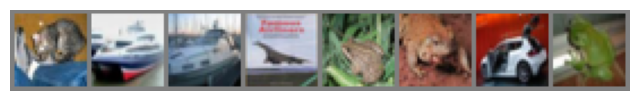

Predicted: ['dog', 'ship', 'ship', 'airplane', 'frog', 'frog', 'truck', 'frog']
Actual:    ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']


In [11]:
# Visualise a few predictions

def show_predictions(model, loader, n=8):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:n], labels[:n]
    with torch.no_grad():
        outputs, _ = model(images.to(device))
        _, preds = torch.max(outputs, 1)

    imshow(torchvision.utils.make_grid(images))
    print("Predicted:", [classes[p] for p in preds.cpu()])
    print("Actual:   ", [classes[l] for l in labels])

show_predictions(model, test_loader)

# Extracting Embeddings and building FAISS Similarity Search Index

In [1]:
import faiss

In [17]:
# Extracting Embeddings and index references from the Train Set

def extract_embeddings(model, dataloader, max_samples=5000):
    model.eval()
    embeddings = []
    labels = []
    indices = []

    with torch.no_grad():
        count = 0
        for batch_idx, (images, lbls) in enumerate(dataloader):
            images = images.to(device)
            _, embs = model(images)

            for i in range(images.size(0)):
                if count >= max_samples:
                    break
                embeddings.append(embs[i].cpu())
                labels.append(lbls[i])
                # Index into train_dataset for later retrieval
                indices.append(batch_idx * dataloader.batch_size + i)
                count += 1
            if count >= max_samples:
                break

    embeddings = torch.stack(embeddings).numpy()
    return embeddings, labels, indices

In [18]:
train_embeddings, train_labels, train_indices = extract_embeddings(model, train_loader)
print("Embeddings shape:", train_embeddings.shape)

Embeddings shape: (5000, 256)


In [19]:
# Create a FAISS index (L2 = Euclidean distance)
index = faiss.IndexFlatL2(train_embeddings.shape[1])
index.add(train_embeddings)
print("FAISS index size:", index.ntotal)

FAISS index size: 5000


# Performing Similarity Search with FAISS

In [20]:
# Define the Search Function

def search_similar_images(model, query_image, index, k=5):
    model.eval()
    with torch.no_grad():
        img = query_image.unsqueeze(0).to(device)
        _, query_embedding = model(img)
        query_embedding = query_embedding.cpu().numpy()
        # FAISS search
        distances, indices = index.search(query_embedding, k)
    return indices[0], distances[0]

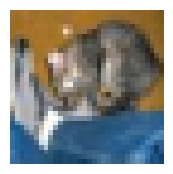

Query label: cat
Top 5 similar images:


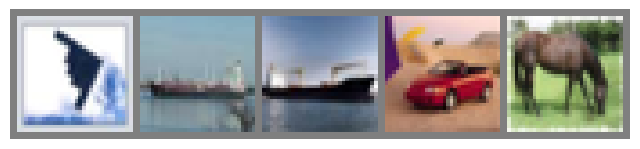

In [21]:
# Get a test image and its label
query_img, query_label = test_dataset[0]
imshow(query_img)
print(f"Query label: {classes[query_label]}")

# Search top 5 similar images
indices, distances = search_similar_images(model, query_img, index, k=5)

# Get matching dataset indices
matched_indices = [train_indices[i] for i in indices]

# Show retrieved images from train_dataset
print("Top 5 similar images:")
similar_imgs = [train_dataset[i][0] for i in matched_indices]
imshow(torchvision.utils.make_grid(similar_imgs))

In [24]:
# Save model
torch.save(model.state_dict(), 'cnn_model.pth')

# Save embeddings and index mapping
np.save('embeddings.npy', train_embeddings)
np.save('indices.npy', train_indices)

# Save class names
import pickle
with open('classes.pkl', 'wb') as f:
    pickle.dump(classes, f)